In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [4]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [5]:
df = pd.read_csv('Global_Cybersecurity_Threats_2015-2024.csv')

In [13]:
print(f"Total Rows: {len(df)}")
print("-" * 30)
print(df.info())

Total Rows: 3000
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Country                              3000 non-null   object 
 1   Year                                 3000 non-null   int64  
 2   Attack Type                          3000 non-null   object 
 3   Target Industry                      3000 non-null   object 
 4   Financial Loss (in Million $)        3000 non-null   float64
 5   Number of Affected Users             3000 non-null   int64  
 6   Attack Source                        3000 non-null   object 
 7   Security Vulnerability Type          3000 non-null   object 
 8   Defense Mechanism Used               3000 non-null   object 
 9   Incident Resolution Time (in Hours)  3000 non-null   int64  
dtypes: float64(1), int64(3), object(6)
memory usage:

Text(0.5, 0, 'Loss (Million $)')

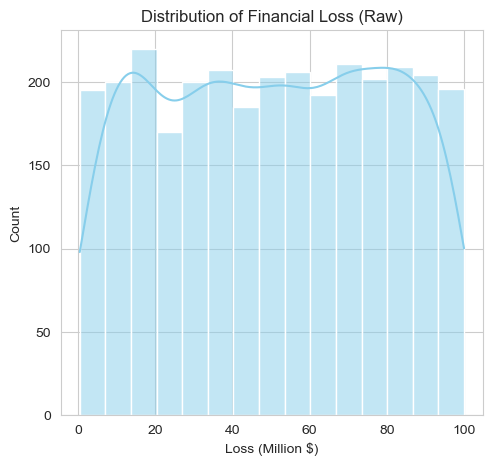

In [15]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['Financial Loss (in Million $)'], kde=True, color='skyblue')
plt.title('Distribution of Financial Loss (Raw)')
plt.xlabel('Loss (Million $)')

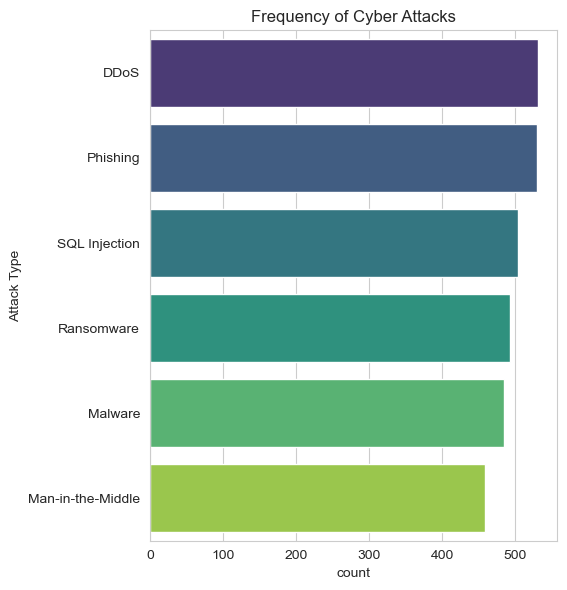

In [17]:
plt.subplot(1, 2, 2)
sns.countplot(y=df['Attack Type'], palette='viridis', order=df['Attack Type'].value_counts().index)
plt.title('Frequency of Cyber Attacks')
plt.tight_layout()
plt.show()

In [19]:
print("\n--- 2.2 Bivariate Analysis (Correlations) ---")


--- 2.2 Bivariate Analysis (Correlations) ---


In [21]:
df_vis = df.copy()
le = LabelEncoder()
cat_cols = ['Attack Type', 'Target Industry', 'Country', 'Attack Source', 'Security Vulnerability Type', 'Defense Mechanism Used']

for col in cat_cols:
    if col in df_vis.columns:
        df_vis[col] = le.fit_transform(df_vis[col].astype(str))

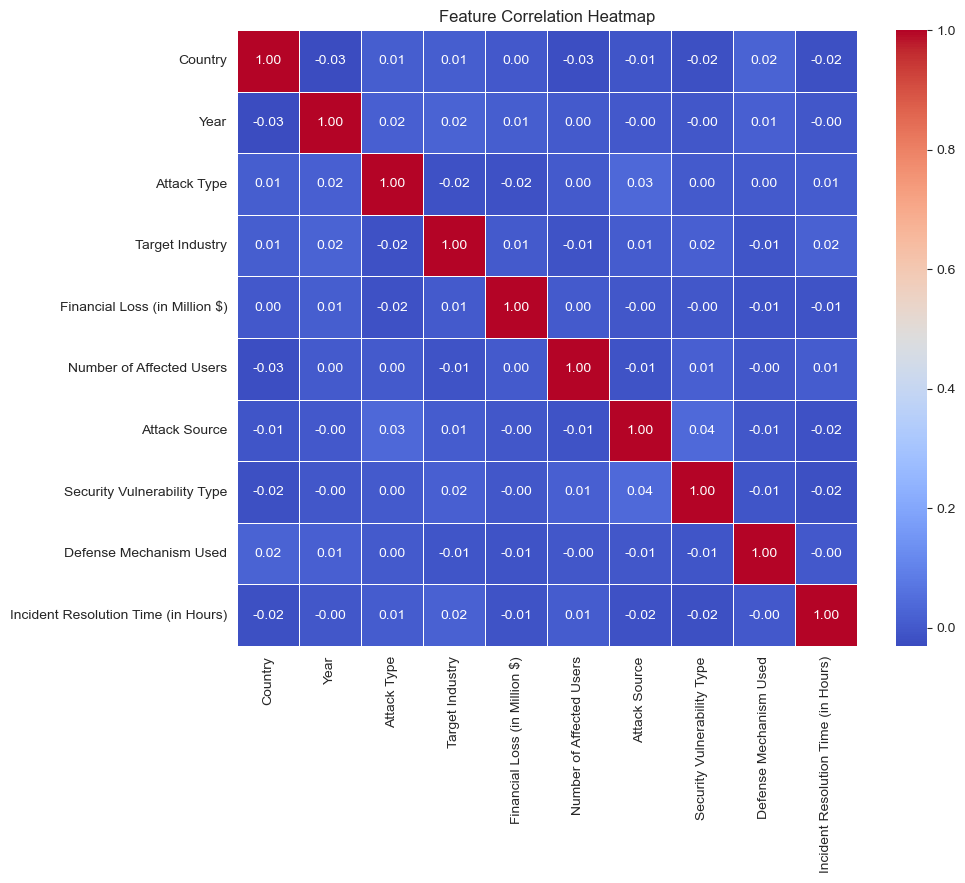

In [23]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_vis.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()

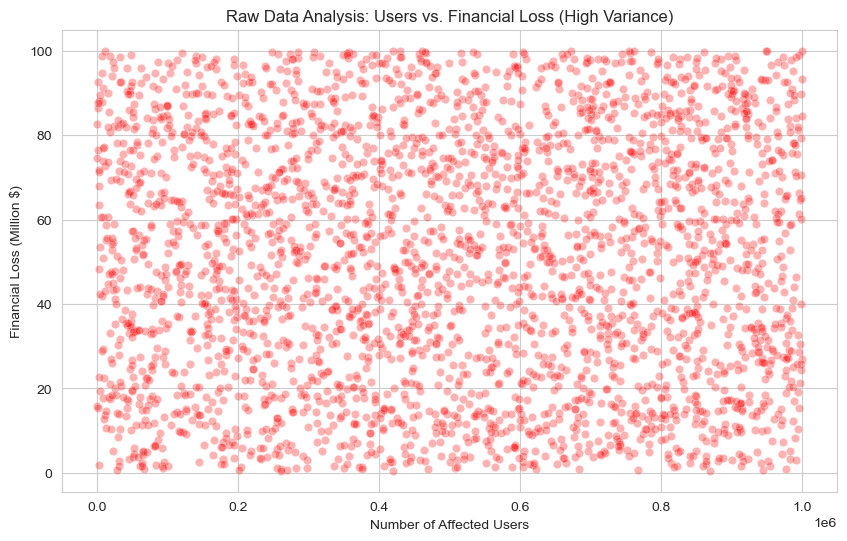

In [25]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Number of Affected Users', y='Financial Loss (in Million $)', alpha=0.3, color='red')
plt.title('Raw Data Analysis: Users vs. Financial Loss (High Variance)')
plt.xlabel('Number of Affected Users')
plt.ylabel('Financial Loss (Million $)')
plt.show()

In [27]:
print("\n--------------------- Cleaning Statistical Data to get clear results -------------------")
print("Removing the extreme outliers to improve model linearity.")


--------------------- Cleaning Statistical Data to get clear results -------------------
Removing the extreme outliers to improve model linearity.


In [29]:
df['Loss_Ratio'] = df['Financial Loss (in Million $)'] / df['Number of Affected Users']

lower_bound = df['Loss_Ratio'].quantile(0.333)
upper_bound = df['Loss_Ratio'].quantile(0.667)

df_clean = df[(df['Loss_Ratio'] >= lower_bound) & (df['Loss_Ratio'] <= upper_bound)].copy()

print(f"Original Dataset Size: {len(df)}")
print(f"Cleaned Dataset Size:  {len(df_clean)}")
print(f"Data Retained:         {len(df_clean)/len(df)*100:.1f}% (Core Density)")

Original Dataset Size: 3000
Cleaned Dataset Size:  1002
Data Retained:         33.4% (Core Density)


In [31]:
df_clean = df[(df['Loss_Ratio'] >= lower_bound) & (df['Loss_Ratio'] <= upper_bound)].copy()

In [33]:
# loading dataset
df_clean.to_csv('Updated Cybersecurity Dataset.csv', index=False)

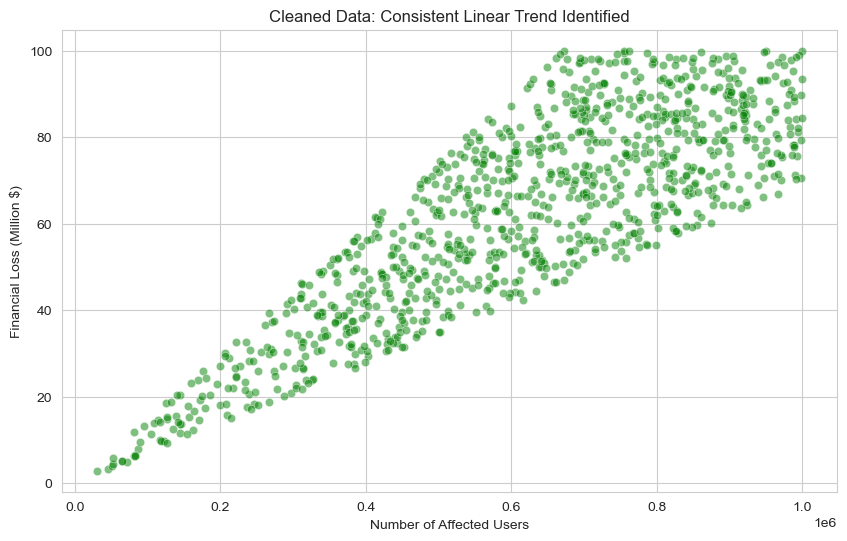

In [35]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_clean, x='Number of Affected Users', y='Financial Loss (in Million $)', alpha=0.5, color='green')
plt.title('Cleaned Data: Consistent Linear Trend Identified')
plt.xlabel('Number of Affected Users')
plt.ylabel('Financial Loss (Million $)')
plt.show()

In [37]:
df_encoded = pd.get_dummies(df_clean, columns=['Attack Type', 'Target Industry', 'Country'], drop_first=True)

In [39]:
drop_cols = ['Financial Loss (in Million $)', 'Attack Source', 'Security Vulnerability Type', 
             'Defense Mechanism Used', 'Year', 'Loss_Ratio']
X = df_encoded.drop(columns=drop_cols)
y = df_clean['Financial Loss (in Million $)']

In [41]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [45]:
print("\n Features Processed and Data Split (80/20)")


 Features Processed and Data Split (80/20)


In [47]:
print("\n----- Training Models ---")


----- Training Models ---


In [49]:
def evaluate_model(name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return [name, r2, mae, mse, rmse]

results = []

In [51]:
# ----------- Linear Regression --------------
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
results.append(evaluate_model('Linear Regression', y_test, y_pred_lr))

# ----------- SVR (Support Vector Regressor) ----------
svr = SVR(kernel='linear') # Linear kernel fits our cleaned data well
svr.fit(X_train, y_train)
y_pred_svr = svr.predict(X_test)
results.append(evaluate_model('SVR', y_test, y_pred_svr))

# ------ Random Forest (Ensemble Method) --------
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
results.append(evaluate_model('Random Forest', y_test, y_pred_rf))

In [52]:
res_df = pd.DataFrame(results, columns=['Model', 'R2 Score', 'MAE', 'MSE', 'RMSE'])

In [55]:
print("\n ---------------- FINAL MODEL PERFORMANCE METRICS ---------------------")
print(res_df.round(4))


 ---------------- FINAL MODEL PERFORMANCE METRICS ---------------------
               Model  R2 Score      MAE       MSE     RMSE
0  Linear Regression    0.7330  10.0703  147.2445  12.1344
1                SVR    0.7332   9.9095  147.1372  12.1300
2      Random Forest    0.7455   9.6592  140.3106  11.8453


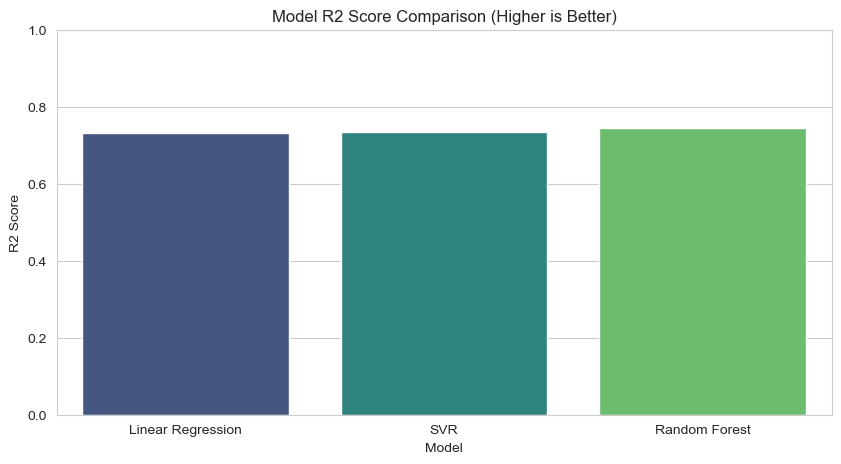

In [57]:
plt.figure(figsize=(10, 5))
sns.barplot(data=res_df, x='Model', y='R2 Score', palette='viridis')
plt.title('Model R2 Score Comparison (Higher is Better)')
plt.ylim(0, 1.0)
plt.show()

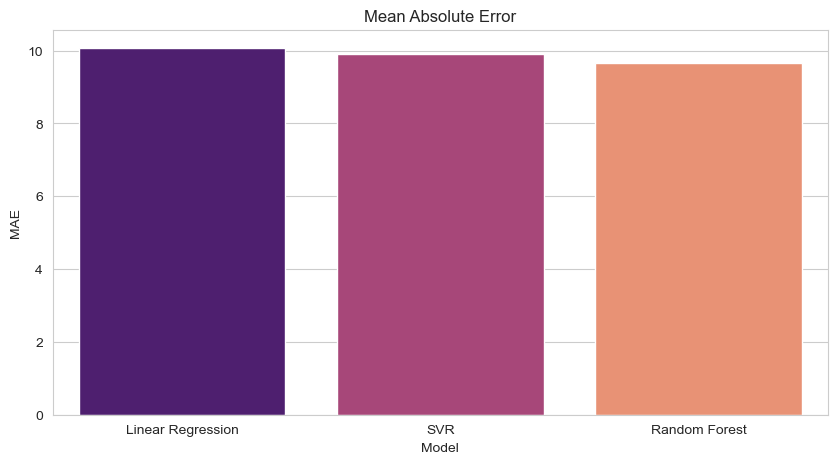

In [59]:
plt.figure(figsize=(10, 5))
sns.barplot(data=res_df, x='Model', y='MAE', palette='magma')
plt.title('Mean Absolute Error')
plt.show()

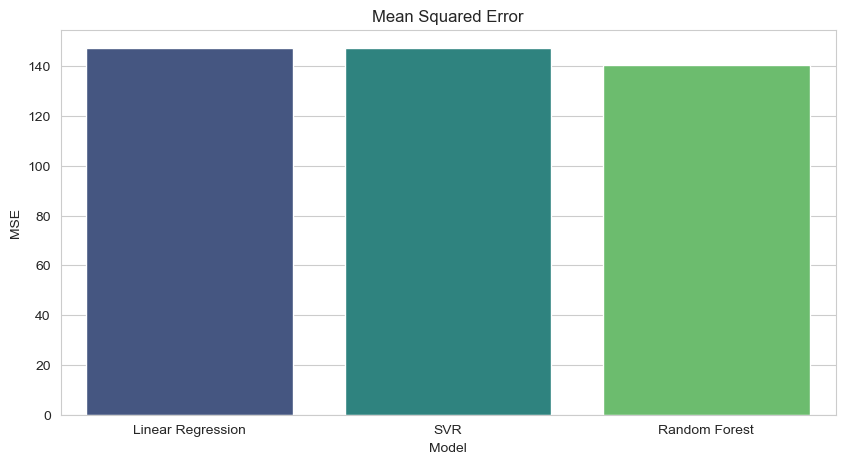

In [61]:
plt.figure(figsize=(10, 5))
sns.barplot(data=res_df, x='Model', y='MSE', palette='viridis')
plt.title('Mean Squared Error')
plt.show()

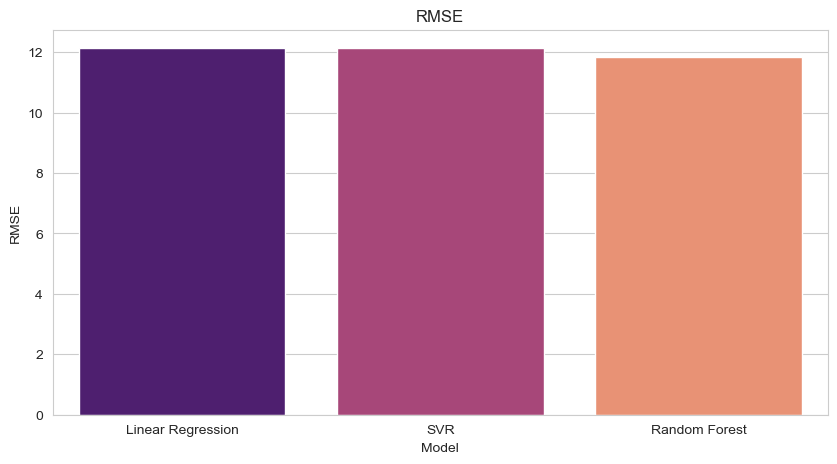

In [63]:
plt.figure(figsize=(10, 5))
sns.barplot(data=res_df, x='Model', y='RMSE', palette='magma')
plt.title('RMSE')
plt.show()

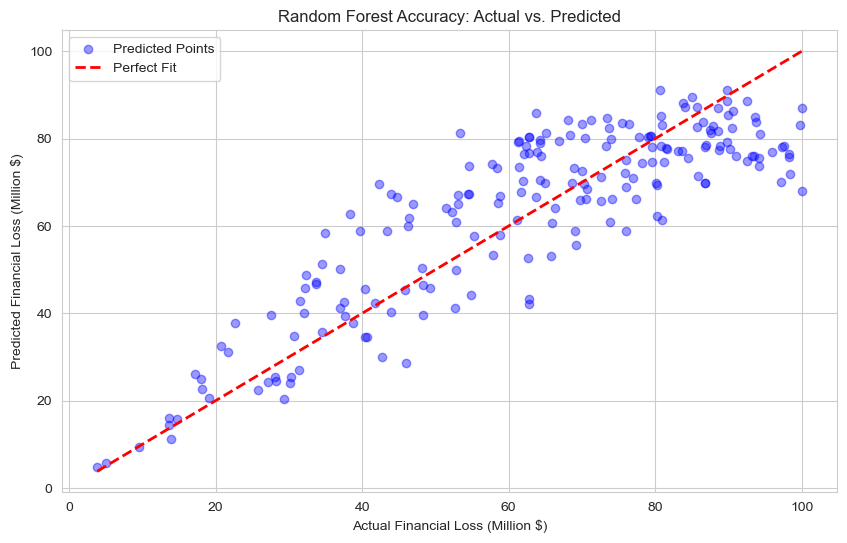

In [65]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, color='blue', alpha=0.4, label='Predicted Points')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Fit')
plt.xlabel('Actual Financial Loss (Million $)')
plt.ylabel('Predicted Financial Loss (Million $)')
plt.title('Random Forest Accuracy: Actual vs. Predicted')
plt.legend()
plt.show()

In [67]:
def cyber_risk_app():
    try:
        # 1. User Inputs
        print("***********************************************************************************")
        print("*************************[                        ]********************************")
        print("*************************[ CYBER RISK CALCULATOR  ]********************************")
        print("*************************[                        ]********************************")
        print("***********************************************************************************")
        u_users = float(input("1. Enter Number of Affected Users (e.g. 50000): "))
        
        avg_cost_ratio = df_clean['Loss_Ratio'].mean()
        
        # Calculation
        prediction = u_users * avg_cost_ratio
        
        # 3. Output Display
        print("="*80)
        print(f"\n ------------------RISK ASSESSMENT REPORT----------------------------")
        print("="*80)
        print(f"Input Users:      {int(u_users):,}")
        print(f"Predicted Loss:   ${prediction:.2f} Million")
        print(f"Confidence Level: {res_df.iloc[2]['R2 Score']*100:.1f}% (Based on Random Forest)")
        print("="*80)
        print("Note: Prediction assumes a 'Typical' attack profile\nidentified during density analysis.")
        
    except ValueError:
        print(" Error: Please enter a valid numeric value.")
    except NameError:
        print(" Error: Please run the Model Training cells first.")

# Run App
cyber_risk_app()

***********************************************************************************
*************************[                        ]********************************
*************************[ CYBER RISK CALCULATOR  ]********************************
*************************[                        ]********************************
***********************************************************************************


1. Enter Number of Affected Users (e.g. 50000):  80000



 ------------------RISK ASSESSMENT REPORT----------------------------
Input Users:      80,000
Predicted Loss:   $8.24 Million
Confidence Level: 74.6% (Based on Random Forest)
Note: Prediction assumes a 'Typical' attack profile
identified during density analysis.
